In [1]:
import mailbox
from datetime import datetime
from datetime import timedelta
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

In [2]:
# compiled regex for getting date sent from email dump
match = re.compile('Date: .*')

# extract the initial send date from the message body
def parse_date(message):
    date_string = re.findall(match, message)[0].split(', ',1)[1]
    date_time = datetime.strptime(date_string,'%b %d, %Y at %I:%M %p')
    return date_time

# create a new column of timedeltas between rows
def create_timedelta(df):
    df = df.sort_values('date')
    df['timedelta'] = df['date'].subtract(df['date'].shift(1))
    return df[1:-1]

def create_email_df(mbox_path):
    # load emails from file
    mbox = mailbox.mbox(mbox_path)
    
    # iterate through email dump and extract all send dates
    date_list = []

    for m in mbox:
        body = m.get_payload(0).as_string()
        date = parse_date(body)
        date_list.append(date)
        
    # create a dataframe with timedeltas
    df = pd.DataFrame({'date':date_list})
    df = create_timedelta(df)

    return df

In [3]:
# load all data
email_df = create_email_df('/srv/zooniverse/raw_data/emails/zooniverse.mbox')
classification_df = pd.read_csv('/srv/zooniverse/tables/all_classifications_table_02-18-19.csv')
project_df = pd.read_csv('/srv/zooniverse/tables/all_projects_table_02-18-19.csv')

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# only use "official" projects and classifications
classification_df = classification_df.loc[classification_df['panoptes_api_official_project'] == 1]
project_df = project_df.loc[(project_df['panoptes_api_official_project'] == 1)]

# only include projects that also have classification data
project_df = project_df.loc[((project_df['panoptes_api'] == 1) & (project_df['ouroboros_dump'] == 1)) | (project_df['panoptes_dump'] == 1) & (project_df['panoptes_api'] == 1)]

# convert classification timestamp to datetime
classification_df['created_at'] = pd.to_datetime(classification_df['created_at'])

# Classification Stats

In [5]:
print('panoptes dump: {0}'.format(len(project_df.loc[project_df['panoptes_dump'] == 1])))
print('panoptes api: {0}'.format(len(project_df.loc[project_df['panoptes_api'] == 1])))
print('ouroboros dump: {0}\n'.format(len(project_df.loc[project_df['ouroboros_dump'] == 1])))
print('panoptes dump + api: {0}'.format(len(project_df.loc[(project_df['panoptes_dump'] == 1) & (project_df['panoptes_api'] == 1)])))
print('panoptes dump + ouroboros dump: {0}'.format(len(project_df.loc[(project_df['panoptes_dump'] == 1) & (project_df['ouroboros_dump'] == 1)])))
print('ouroboros dump + panoptes api: {0}\n'.format(len(project_df.loc[(project_df['panoptes_api'] == 1) & (project_df['ouroboros_dump'] == 1)])))
print('only panoptes dump: {0}'.format(len(project_df.loc[(project_df['panoptes_dump'] == 1) & (project_df['panoptes_api'] == 0) & (project_df['ouroboros_dump'] == 0)])))
print('only panoptes api: {0}'.format(len(project_df.loc[(project_df['panoptes_dump'] == 0) & (project_df['panoptes_api'] == 1) & (project_df['ouroboros_dump'] == 0)])))
print('only ouroboros dump: {0}\n'.format(len(project_df.loc[(project_df['panoptes_dump'] == 0) & (project_df['panoptes_api'] == 0) & (project_df['ouroboros_dump'] == 1)])))

panoptes dump: 65
panoptes api: 84
ouroboros dump: 19

panoptes dump + api: 65
panoptes dump + ouroboros dump: 0
ouroboros dump + panoptes api: 19

only panoptes dump: 0
only panoptes api: 0
only ouroboros dump: 0



# Email stats

In [95]:
print('total emails: {0}'.format(len(email_df)))
print('emails sent during classification data: {0}'.format(len(email_df.loc[email_df['date'] < classification_df['created_at'].max()])))
print('emails sent after classification data: {0}'.format(len(email_df.loc[email_df['date'] > classification_df['created_at'].max()])))

total emails: 53
emails sent during classification data: 12
emails sent after classification data: 41


In [109]:
def lifespan(classification_df, email_df, title=None):
    first_classification = classification_df.groupby('panoptes_project_id')['created_at'].min().to_frame('first').reset_index()
    last_classification = classification_df.groupby('panoptes_project_id')['created_at'].max().to_frame('last').reset_index()
    project_lifespan_df = project_df[['panoptes_project_name','panoptes_project_id']].merge(first_classification, on='panoptes_project_id').merge(last_classification, on='panoptes_project_id')
    project_lifespan_df['mid'] = project_lifespan_df['last'].subtract(project_lifespan_df['first']).divide(2)

    fig = plt.figure(figsize=(12,24))
    #result_df = result_df.sort_values(by='b')
    '''if graph_type == 'bars':
        lw=4
        plt.errorbar(x=result_df['50%'],
                 y=np.arange(len(result_df)),
                 xerr=[result_df['50%'], result_df['b'].subtract(result_df['50%'])],
                 fmt='none',
                 ecolor='grey',
                 lw=2)

    plt.plot(result_df['b'],
             np.arange(len(result_df)),
             '.')
    lw=1'''
    plt.plot([project_lifespan_df['first'].values,project_lifespan_df['last'].values],
             [np.arange(len(project_lifespan_df)),np.arange(len(project_lifespan_df))],
             '.')
    plt.errorbar(x=project_lifespan_df['first'].add(project_lifespan_df['mid']).values,
                 y=np.arange(len(project_lifespan_df)),
                 xerr=[project_lifespan_df['mid'].values,
                       project_lifespan_df['mid'].values],
                 lw=1,
                 ecolor='gray',
                 fmt='none')
                     #xerr=[project_lifespan_df['first'].values,
                     #      project_lifespan_df['last'].values],
                     #lw=1,
                     #ecolor='gray',
                     #fmt='none')
    plt.yticks(np.arange(len(project_lifespan_df)), project_lifespan_df['panoptes_project_name'])
    plt.xticks(rotation='vertical')
    plt.vlines(x=email_df.loc[email_df['date'] < classification_df['created_at'].max()]['date'].values,
               ymin=0,
               ymax=len(project_lifespan_df),
               linestyles='dashed',
               lw=1)
    if title:
        plt.title(title)

    plt.xlabel('Date')
    plt.tight_layout()

# Project Lifespans and Newsletters

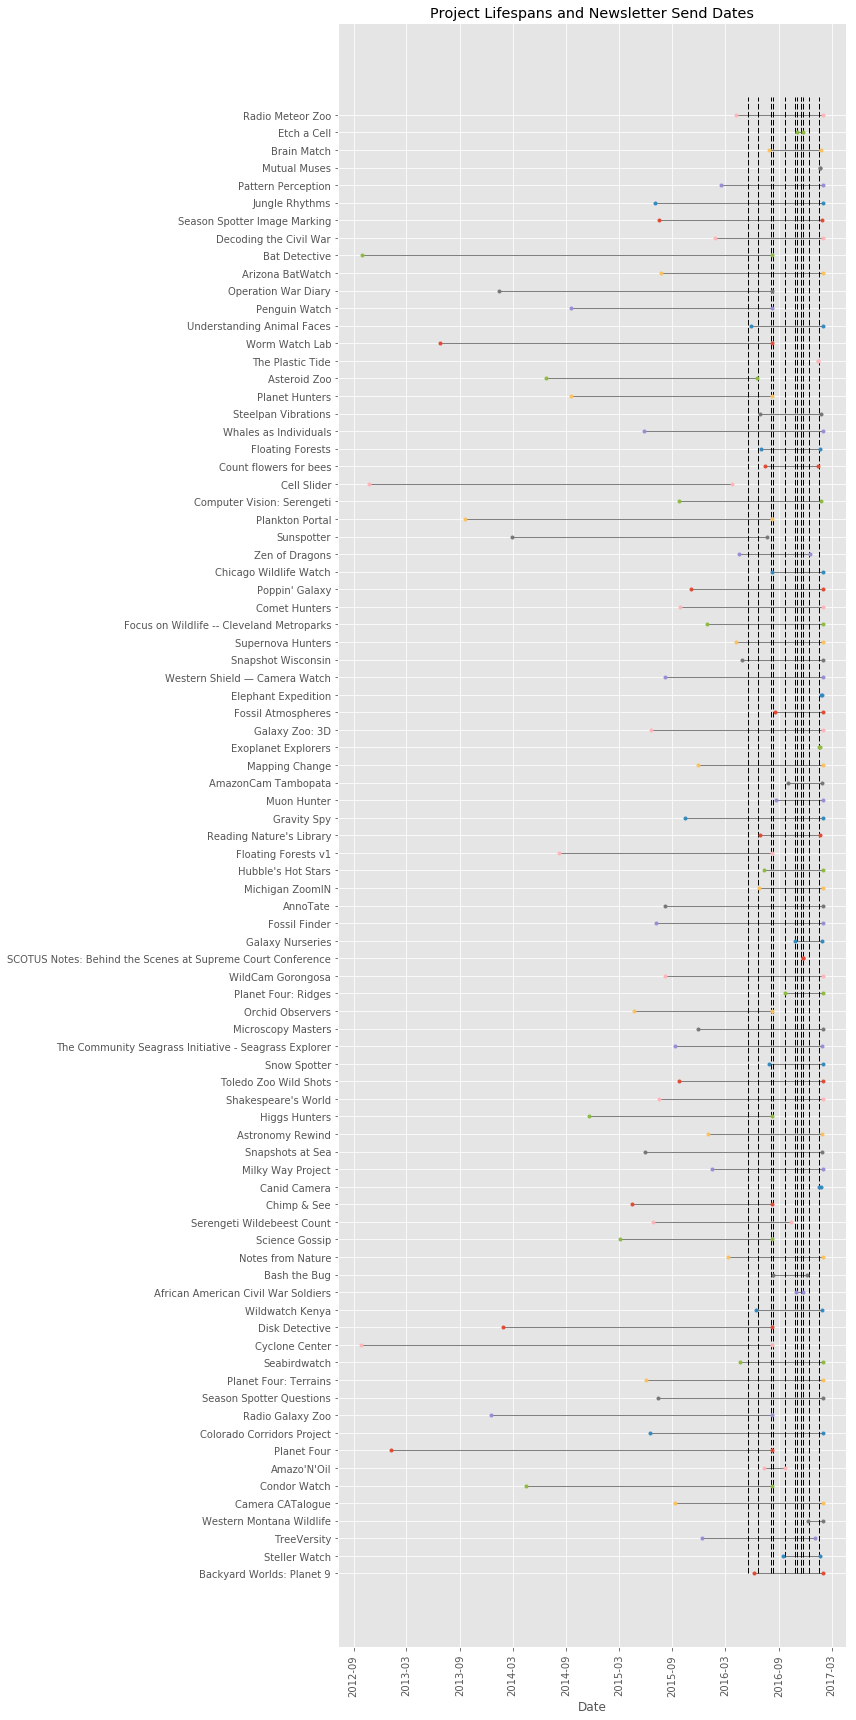

In [110]:
lifespan(classification_df=classification_df,
         email_df=email_df,
         title='Project Lifespans and Newsletter Send Dates')

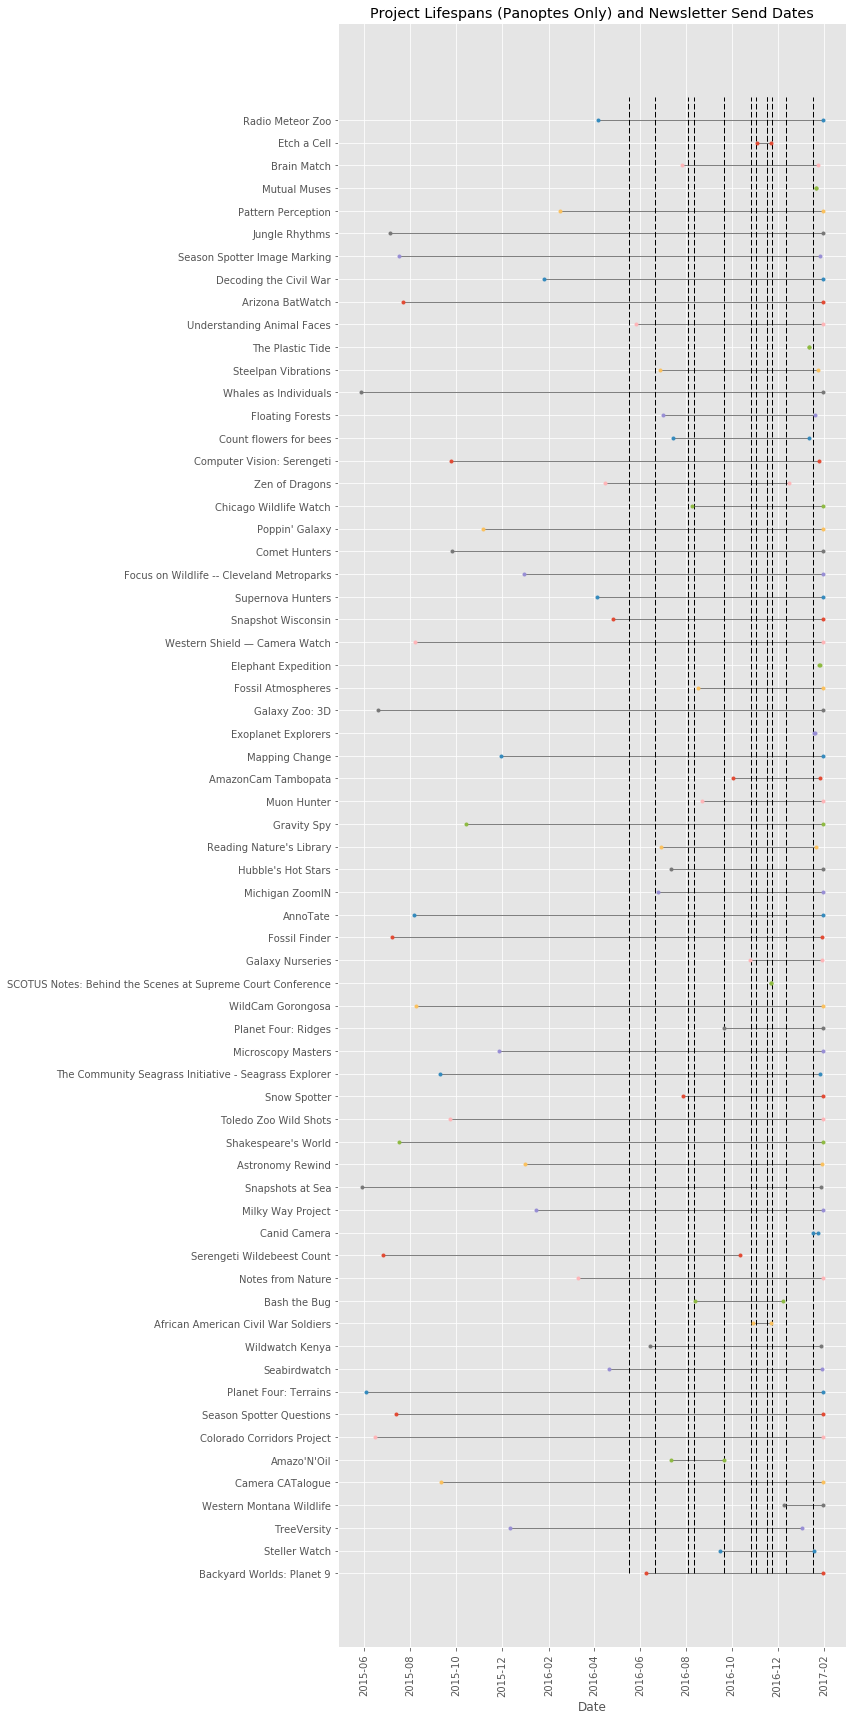

In [111]:
lifespan(classification_df=classification_df.loc[classification_df['panoptes_dump'] == 1],
         email_df=email_df,
         title='Project Lifespans (Panoptes Only) and Newsletter Send Dates')

In [230]:
def get_weeks(x):
    return x.isocalendar()[0]*52+x.isocalendar()[1]

def classifications_by_time(classification_df, email_df, title=None):
    classification_df['iso_week'] = classification_df['created_at'].apply(get_weeks)
    classifications_by_week = classification_df.merge(project_df[['panoptes_project_name','panoptes_project_id']],on='panoptes_project_id',how='left')
    classifications_by_week = classifications_by_week.groupby(['panoptes_project_name','iso_week'])['iso_week'].size().unstack(level=0)
    classifications_by_week.plot(figsize=(12,12),legend=False)
    
    email_df['iso_week'] = email_df['date'].apply(get_weeks)
    plt.vlines(x=email_df.loc[email_df['iso_week'] < classification_df['iso_week'].max()]['iso_week'].tolist(),
               ymin=0,
               ymax=classifications_by_week.max().max(),
               linestyles='dashed',
               lw=1)
    
    plt.xlabel('ISO Date (Years * 52 + Weeks)')
    plt.ylabel('Number of Classifications')
    plt.tight_layout()
    
    if title:
        plt.title(title)

# Classifications over time (per project).  Verticle lines represent newsletter send dates.

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


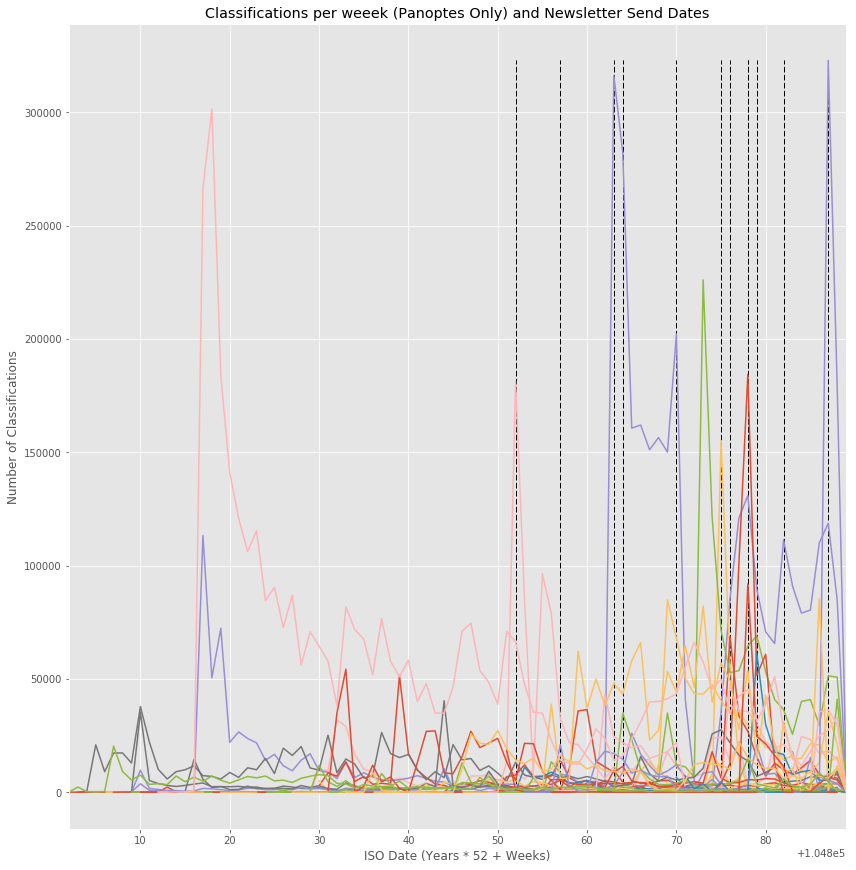

In [231]:
classifications_by_time(classification_df=classification_df.loc[classification_df['panoptes_dump'] == 1],
                        email_df=email_df,
                        title='Classifications per weeek (Panoptes Only) and Newsletter Send Dates')

In [298]:
def single_email_plot(classification_df, email_df, email_iso_week_list=None, week_window=4, title=None):
    classification_df['iso_week'] = classification_df['created_at'].apply(get_weeks)
    classifications_by_week = classification_df.merge(project_df[['panoptes_project_name','panoptes_project_id']],on='panoptes_project_id',how='left')
    classifications_by_week = classifications_by_week.groupby(['panoptes_project_name','iso_week'])['iso_week'].size().unstack(level=0)
    classifications_by_week.reset_index(inplace=True)
    
    email_df['iso_week'] = email_df['date'].apply(get_weeks)
    
    if not email_iso_week_list:
        email_iso_week_list = email_df['iso_week'].values
        
    for email_iso_week in email_iso_week_list:
        _single_email_plot(classifications_by_week=classifications_by_week,
                           email_iso_week=email_iso_week,
                            email_df=email_df,
                            week_window=week_window,
                            title=title)
        
def _single_email_plot(classifications_by_week, email_iso_week, email_df, week_window=4, title=None):
    start_range = email_iso_week - week_window
    end_range = email_iso_week + week_window
    windowed_classifications_by_week = classifications_by_week.loc[(classifications_by_week['iso_week'] >= start_range) & (classifications_by_week['iso_week'] <= end_range)]
    windowed_classifications_by_week = windowed_classifications_by_week.set_index('iso_week')
    windowed_classifications_by_week.plot(figsize=(12,12), legend=False)

    plt.vlines(x=email_df.loc[email_df['iso_week'] < end_range]['iso_week'].tolist(),
               ymin=0,
               ymax=windowed_classifications_by_week.max().max(),
               linestyles='dashed',
               lw=1)

    plt.xlabel('ISO Date (Years * 52 + Weeks)')
    plt.ylabel('Number of Classifications')
    plt.tight_layout()

    if title:
        plt.title(title)

# Classifications over time (per project) for a 4 week window surrounding each newsletter.  Verticle lines represent newsletter send dates.

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


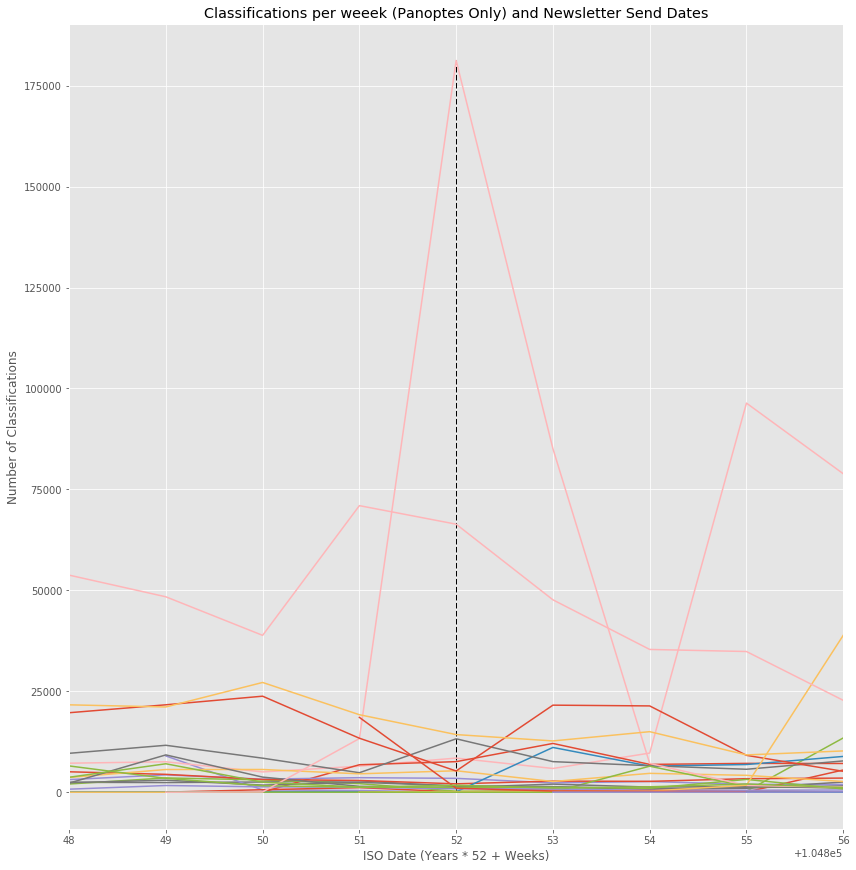

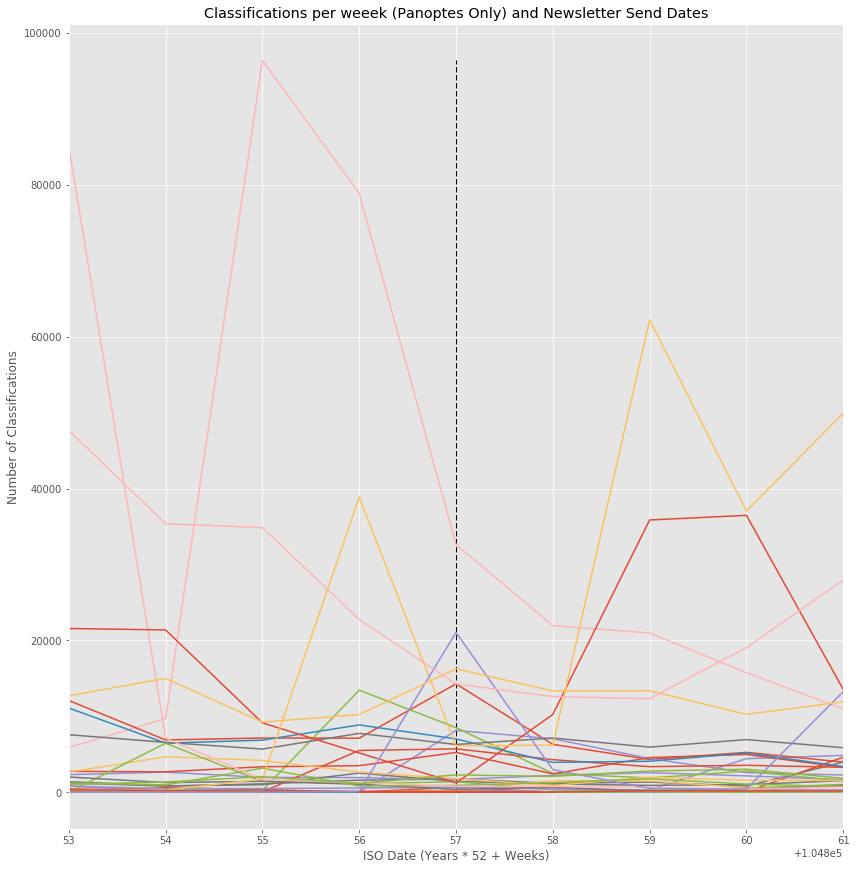

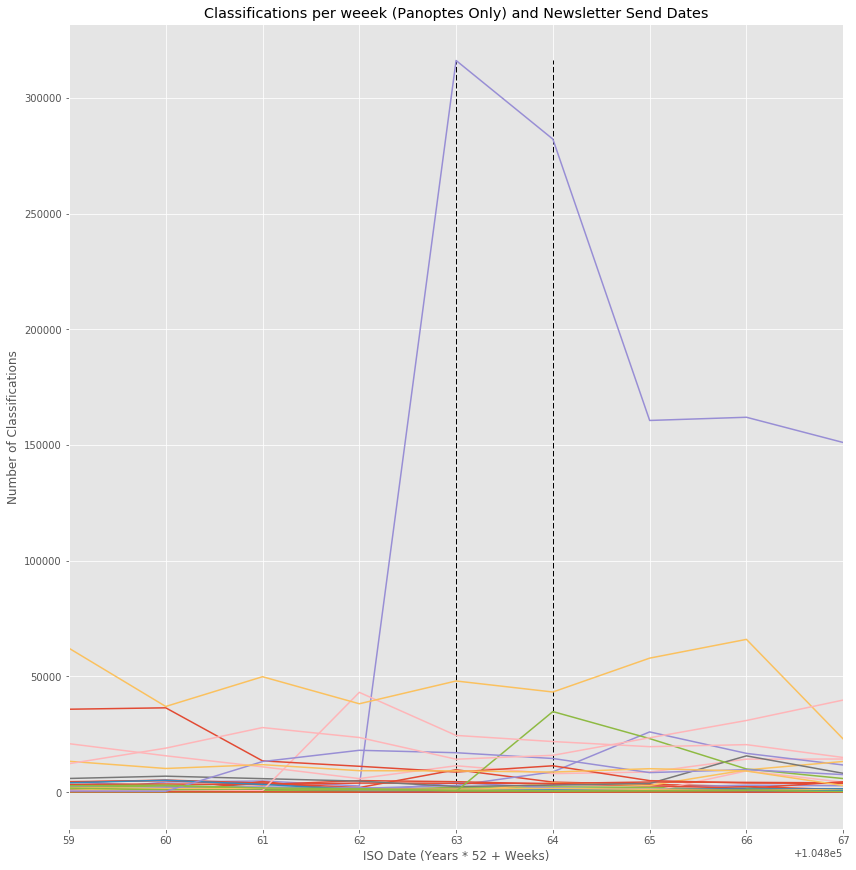

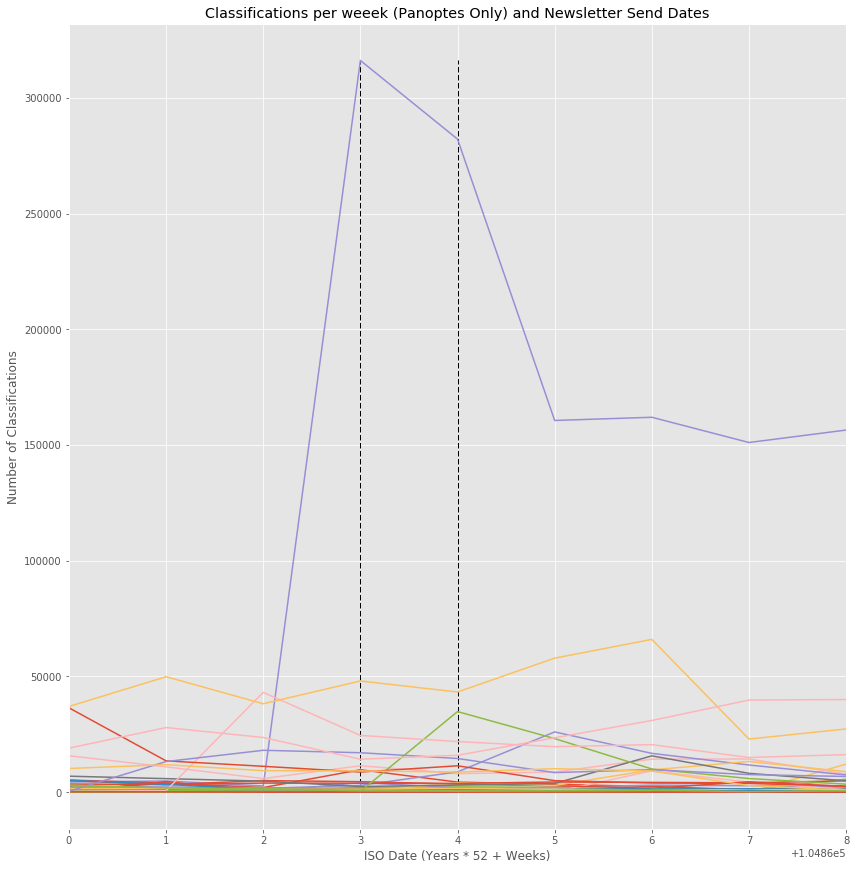

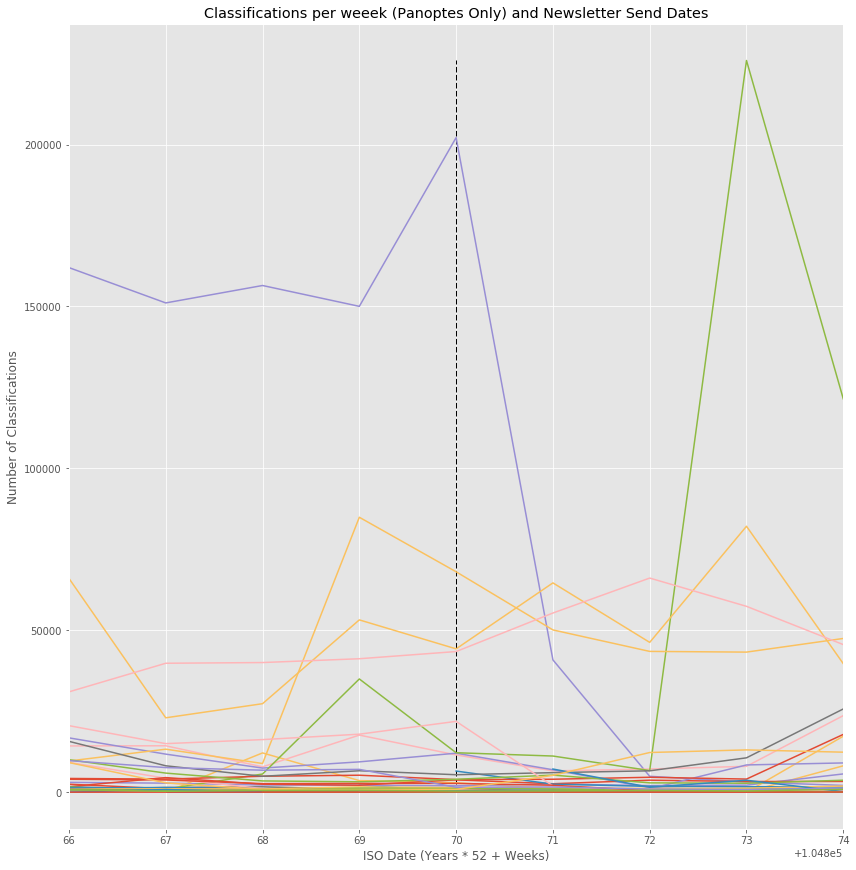

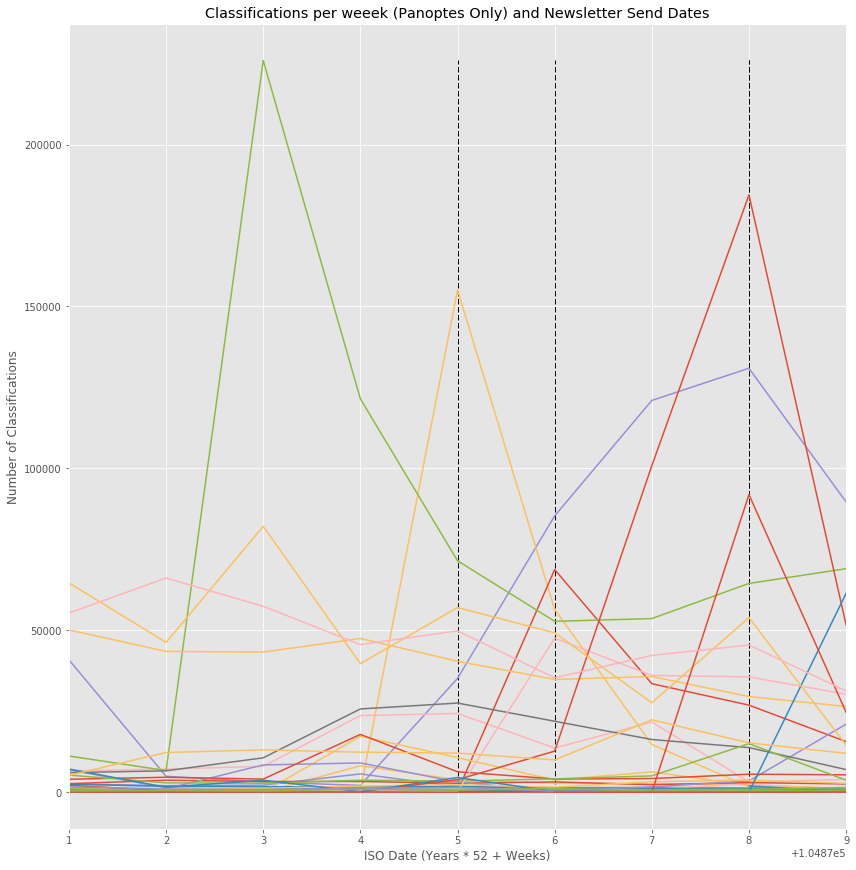

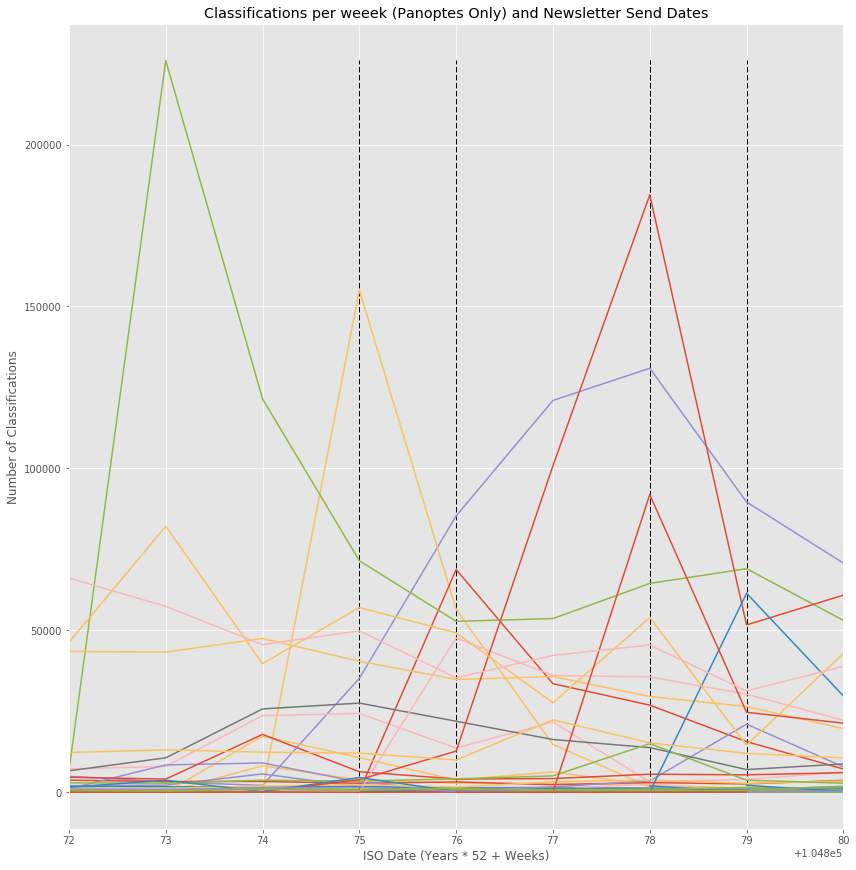

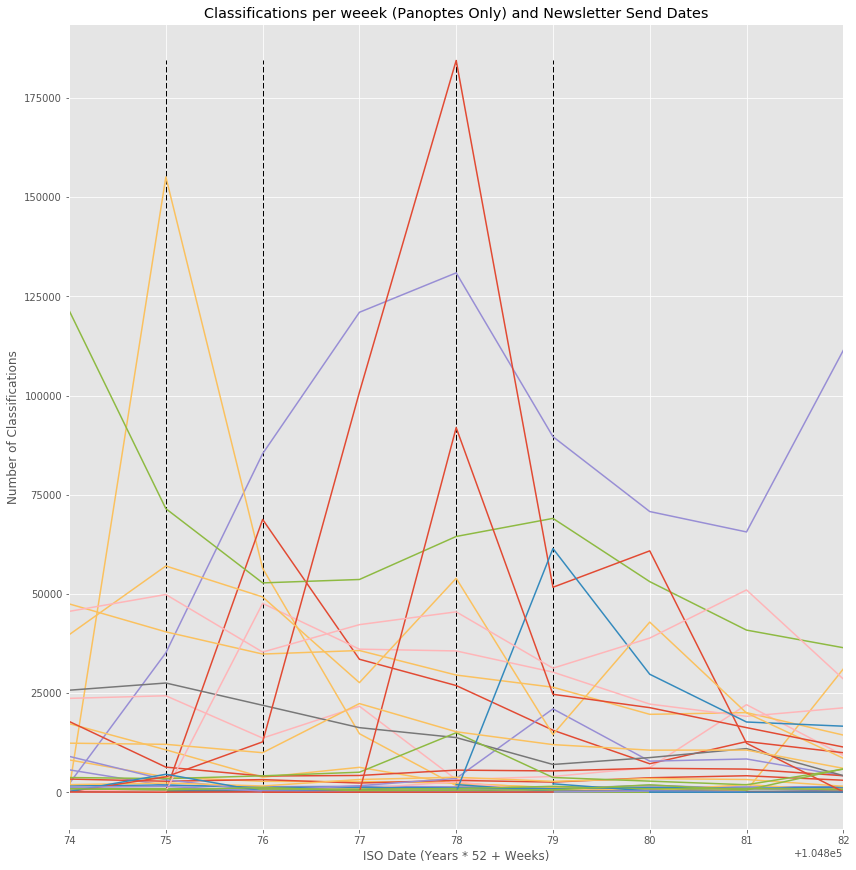

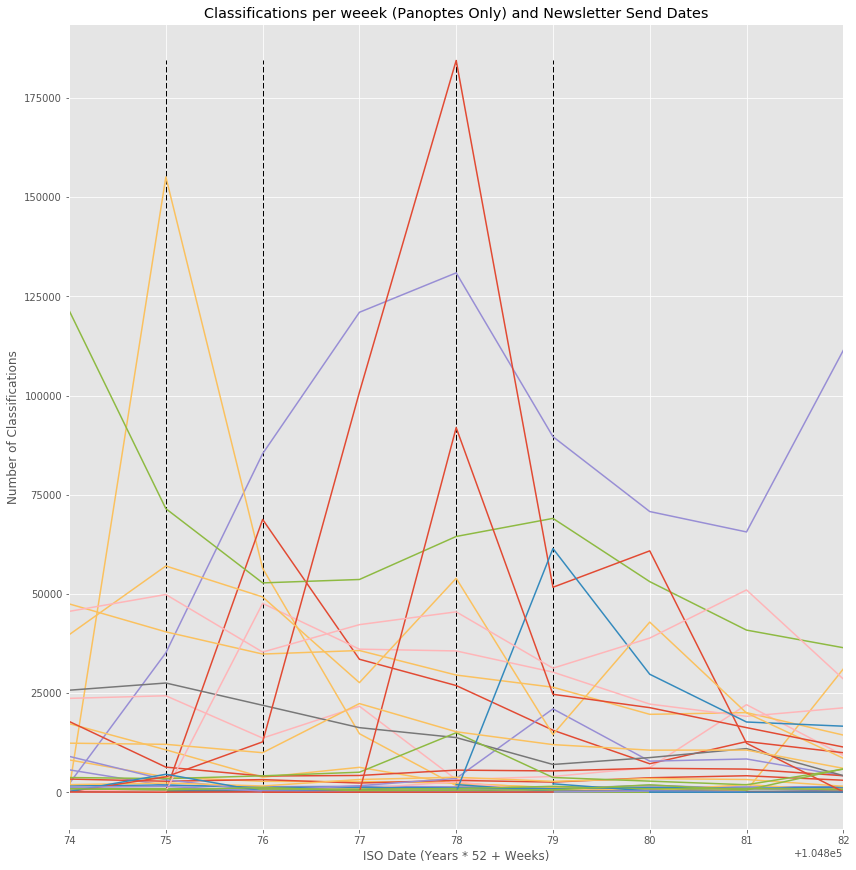

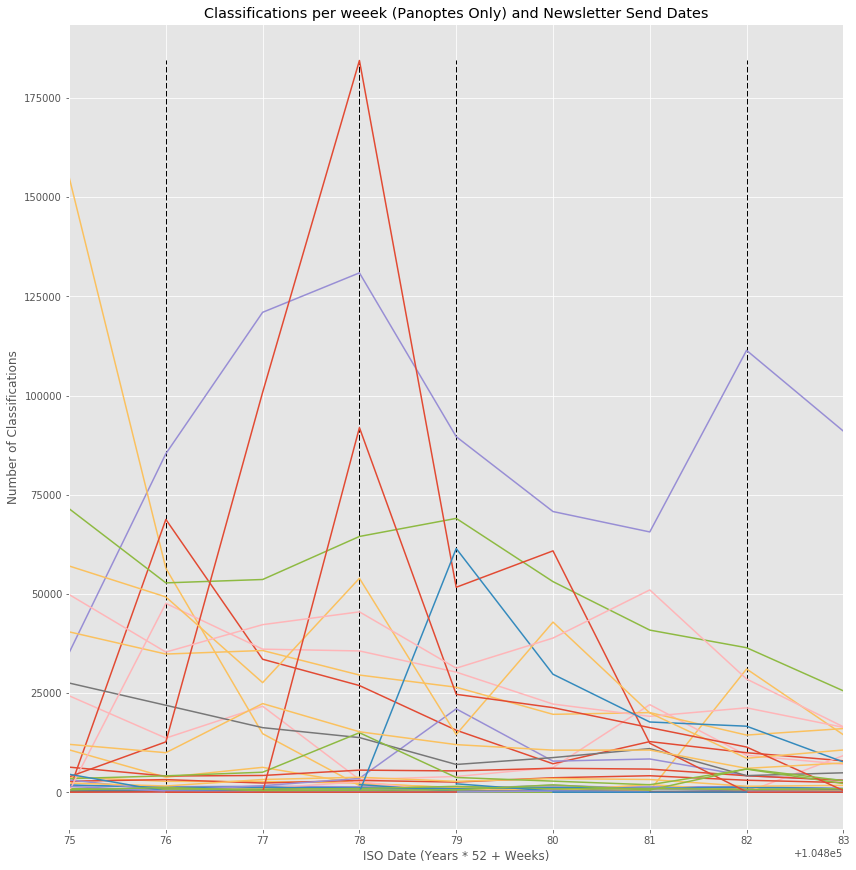

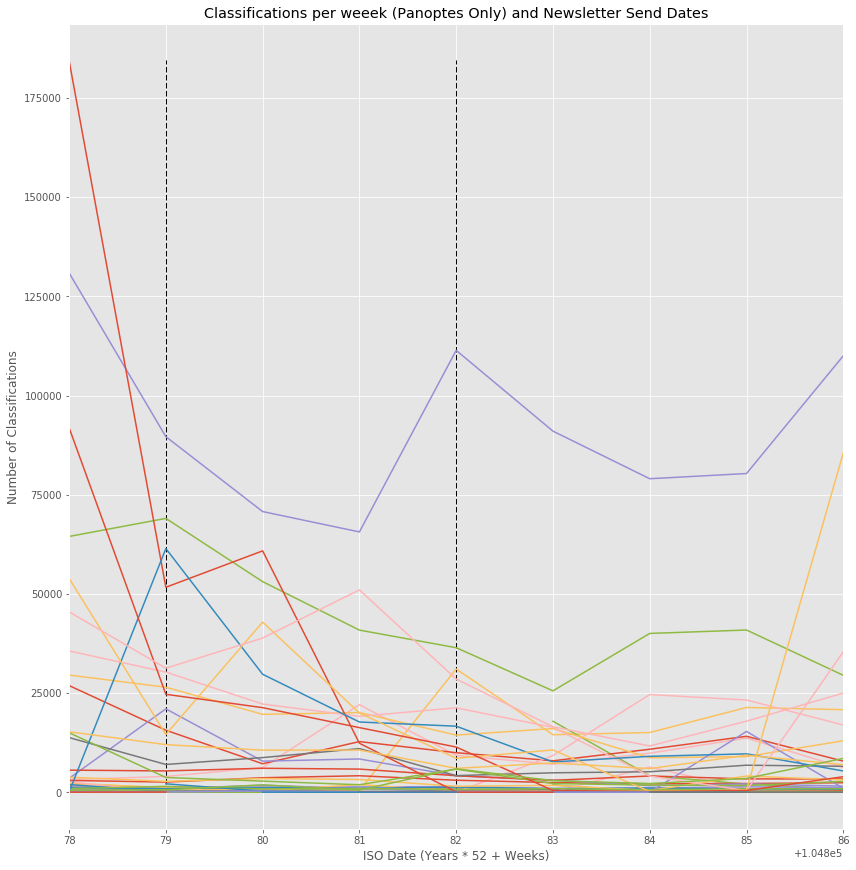

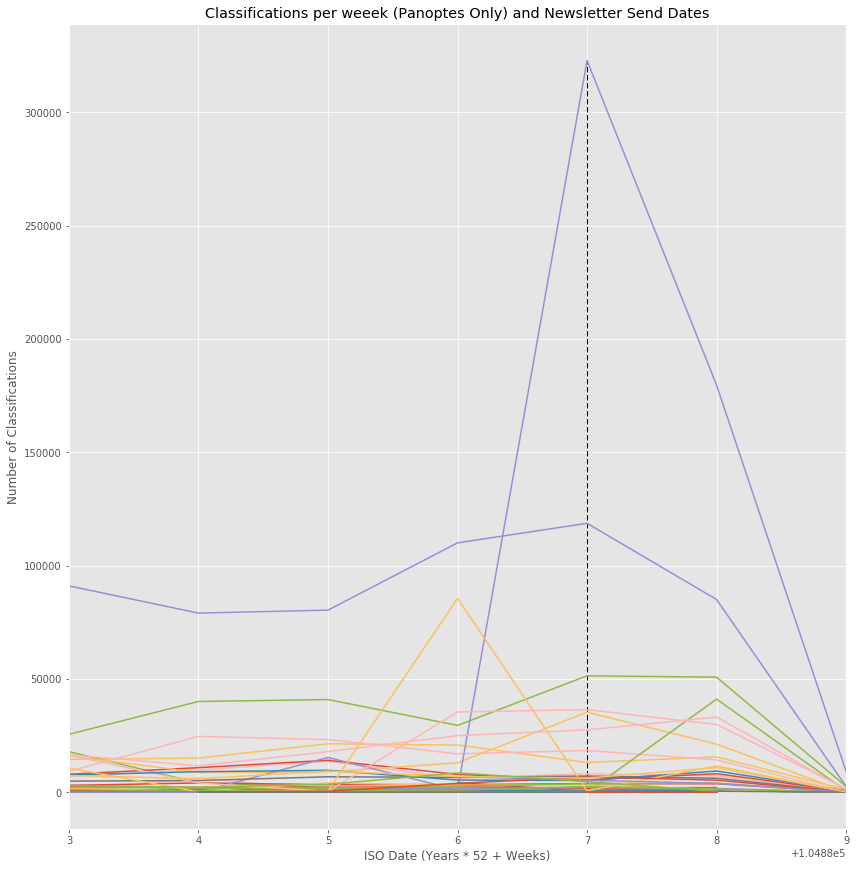

In [299]:
single_email_plot(classification_df=classification_df.loc[classification_df['panoptes_dump'] == 1],
                  email_df=email_df.loc[email_df['iso_week'] < classification_df['iso_week'].max()],
                  title='Classifications per weeek (Panoptes Only) and Newsletter Send Dates')

In [335]:
def calculate_email_overlap(email_df,high,low=1, title=None):
    overlap = []
    for week_window in range(low,high):
        non_overlap_count = 0
        for email_iso_week in email_df['iso_week'].values:
            start_range = email_iso_week - week_window
            end_range = email_iso_week + week_window

            if len(email_df.loc[(email_df['iso_week'] >= start_range) & (email_df['iso_week'] <= end_range)]) == 1:
                non_overlap_count += 1
        overlap.append(non_overlap_count)
    plt.bar(left=np.arange(low,high),
            height=overlap)
    plt.xlabel('Window Length (in weeks)')
    plt.ylabel('Number of Non-Overlapping Windows')

    if title:
        plt.title(title)


# Number of non-overlapping subsets of data we could create for time windows (bandwidths) of different lengths.

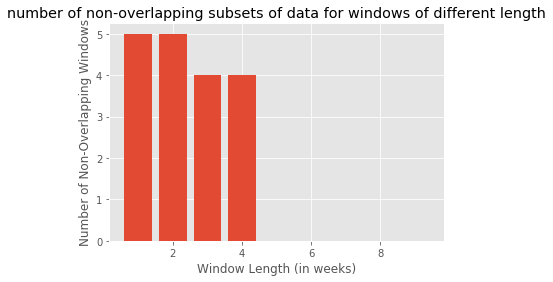

In [336]:
calculate_email_overlap(email_df=email_df.loc[email_df['iso_week'] < classification_df['iso_week'].max()],
                        high=10,
                        low=1,
                        title='number of non-overlapping subsets of data for windows of different length')